# JWST MIRI MRS reductions for point sources 

**Author**: Melissa Shahbandeh
<br>
**Last Updated**: August, 2023

If you use this notebook, please consider citing the GitHub link and Shahbandeh et al. 2023b in prep

## Table of contents
1. [Introduction](#intro)<br>
2. [Setup](#setup)<be>\
    2.1 Define a path, name of the target, and PID\
    2.2 Python imports\
    2.3 Change the following accordingly to define your CRDS path\
    2.4 Define directories/paths\
    2.5 Organizing data
3. Creating the unsubtracted cube\
    3.1 Running stage 1\
    3.2 Removing bad pixels\
    3.3 Running stage 2\
    3.4 Running stage 3\
    3.5 Let's take a look at the cube
4. Construct a master background\
    4.1 Defining the extraction functions and finding where the target is\
    4.2 Defining the background regions and extract them\
    4.3  Averaging the background spectra to get the master background and then plot them\
    4.4  Create background subtracted cube\
    4.5 Let's take a look at the subtracted cube
5. Residual backgrounds\
    5.1 Changing the source type\
    5.2 Extract residual backgrounds from the subtracted cube\
    5.3 Averaging the background spectra to get the mean residual background and then plot them
6. Comparison\
    6.1 Plotting all backgrounds and residuals to compare\
    6.2 Perform an annulus on the subtracted cube to reduce the noise
7. Plot all of the residual backgrounds and the target spectrum  

1.<font color='white'>-</font>Introduction <a class="anchor" id="intro"></a>
------------------

**Goals**: 

Some of the MIRI/MRS targets are either located in the regions with high/complicated backgrounds, or are too faint, or both. This is an attempt to find a better way than what the current pipeline offers to subtract/mitigate the effect of these high background regions. The official pipeline uses an annulus around the target to subtract the background, which is not ideal in the cases with highly varying backgrounds. 

This notebook shows:

1) How to construct a background that is more representative of the background variation
2) How to subtract the background and extract the final spectrum


**Data**: 

jwst_download.py -v --config jwst_query.cfg --propID 1171 --obsnums 4 --outrootdir ./mydownloads/ -l 500 --i miri --obsmode image --token YOUR_TOKEN_HERE --filetypes '_asn.json'

2.<font color='white'>-</font>Setup <a class="anchor" id="setup"></a>
------------------

### 2.1<font color='white'>-</font>Define a path, name of the target, and PID<a class="anchor" id="Define a path, name of the target, and PID"></a> ###

In [3]:
PID, SN = 1866, '2005ip'
path = '/Users/mshahbandeh/JWST/'

### 2.2<font color='white'>-</font>Python imports<a class="anchor" id="Python imports"></a> ###

In [67]:
import re,sys,os,pdb
import glob
import time
import shutil
import warnings
import zipfile
import urllib.request
import jwst
from jwst.stpipe import Step
from jwst.combine_1d import Combine1dStep
from specutils import Spectrum1D, SpectrumList
import numpy as np
from astropy.io import fits
from astropy.io import ascii
from astropy.utils.data import download_file
from astropy.visualization import (LinearStretch, LogStretch, ImageNormalize, ZScaleInterval)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize,LogNorm
from matplotlib import rc
from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Spec2Pipeline
from jwst.pipeline import Spec3Pipeline
from jwst import datamodels
from jwst.associations import asn_from_list as afl
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base
from stcal import dqflags
import multiprocessing
from multiprocessing import Pool
usage = 'all'
import matplotlib.cm as cmap
import sklearn.preprocessing as preprocess
from jwst.assign_wcs import AssignWcsStep
from jwst.background import BackgroundStep
from jwst.flatfield import FlatFieldStep
from jwst.srctype import SourceTypeStep
from jwst.straylight import StraylightStep
from jwst.fringe import FringeStep
from jwst.photom import PhotomStep
from jwst.cube_build import CubeBuildStep
from jwst.extract_1d import Extract1dStep
from jwst.cube_skymatch import CubeSkyMatchStep
from jwst.master_background import MasterBackgroundStep
from jwst.outlier_detection import OutlierDetectionStep
import jdaviz
from jdaviz import Cubeviz
from jwst.datamodels import JwstDataModel, SpecModel, MultiSpecModel, IFUCubeModel, ModelContainer, IFUImageModel
import warnings
import matplotlib.patches as patches
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5
from astropy.table import Table
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder, CircularAperture
from scipy.ndimage import gaussian_filter1d
warnings.filterwarnings("ignore")
print(jwst.__version__)

1.11.1.dev33+g7556988f


### 2.3<font color='white'>-</font>Change the following accordingly to define your CRDS path<a class="anchor" id="Change the following accordingly to define your CRDS path"></a> ###

In [ ]:
# os.environ["CRDS_SERVER_URL"] = "https://jwst-crds-pub.stsci.edu"`
# os.environ["CRDS_PATH"] = "/user/myself/crds_cache"`

### 2.4<font color='white'>-</font>Define directories/paths<a class="anchor" id="Define directories/paths"></a> ###

In [68]:
## Point to where you want the output science results to go
output_dir = path + f'{PID}/{SN}/'

dodet1=True
dospec2=True
dospec3=True
dodet1bg=False
dospec2bg=False
  
## Output subdirectories to keep science data products organized
## Note that the pipeline might complain about this as it is intended to work with everything in a single
## directory, but it nonetheless works fine for the examples given here.
uncal_dir = os.path.join(output_dir, 'stage0/') # Uncalibrated files should be here
det1_dir = os.path.join(output_dir, 'stage1/') # Detector1 pipeline outputs will go here
spec2_dir = os.path.join(output_dir, 'stage2/') # Spec2 pipeline outputs will go here
spec3_dir = os.path.join(output_dir, 'stage3/') # Spec3 pipeline outputs will go here
bg_dir = os.path.join(spec3_dir, 'bgs/') # Background files will go here

# We need to check that the desired output directories exist, and if not create them
if not os.path.exists(det1_dir):
    os.makedirs(det1_dir)
if not os.path.exists(spec2_dir):
    os.makedirs(spec2_dir)
if not os.path.exists(spec3_dir):
    os.makedirs(spec3_dir)
if not os.path.exists(bg_dir):
    os.makedirs(bg_dir)

# Start a timer to keep track of runtime
time0 = time.perf_counter()

### 2.5<font color='white'>-</font>Organizing data<a class="anchor" id="Organizing data"></a> ###

Download the uncalibrated files and put them in "uncal_dir" (if you have 4 dithers, you should have 24 files in your uncal_dir)
You can skip this stage and instead download the rate files and put them det1_dir in rate files and put them in det1_dir, if you do so then skip to 3.2

3.<font color='white'>-</font>Creating the unsubtracted cube<a class="anchor" id="Creating the unsubtracted cube"></a>
------------------

### 3.1<font color='white'>-</font>Running stage 1<a class="anchor" id="Running stage 1"></a>

### 3.2<font color='white'>-</font>Removing bad pixels<a class="anchor" id="Removing bad pixels"></a>

This is optional in case your data is very noisy and has a lot of bad pixels. DO NOT try it if you expect to have lots of narrow emission lines.

### 3.3<font color='white'>-</font>Running stage 2<a class="anchor" id="Running stage 2"></a>

### 3.4<font color='white'>-</font>Running stage 3<a class="anchor" id="Running stage 3"></a>

### 3.5<font color='white'>-</font>Let's take a look at the cube<a class="anchor" id="Let's take a look at the cube"></a>

In [70]:
cubeviz = Cubeviz()
cubeviz.load_data(spec3_dir+f'{SN}_POINT_ch1-2-3-4-shortmediumlong_s3d.fits')
cubeviz.app

Application(config='cubeviz', events=['call_viewer_method', 'close_snackbar_message', 'data_item_remove', 'dat…

4.<font color='white'>-</font>Construct a master background<a class="anchor" id="Construct a master background"></a>
------------------

### 4.1<font color='white'>-</font>Defining the extraction functions and finding where the target is<a class="anchor" id="Defining the extraction functions and finding where the target is"></a>

In [71]:
# Defining the extraction function
def runex(filename, outdir, outputfile):
    ex1d = jwst.extract_1d.Extract1dStep()
    ex1d.output_dir = outdir
    ex1d.save_results = True
    ex1d.subtract_background = False # Do not change
    ex1d.output_file = outputfile
    ex1d(filename)  

########################################################################
# Defining the averaging function
def SBM(spectra_list):
    SBs, FLs, BKs = [], [], []
    for i in range(len(spectra_list)):
        file = fits.open(spectra_list[i])
        spec = file['EXTRACT1D'].data[0::]
        SBs.append(spec['SURF_BRIGHT'])
        FLs.append(spec['FLUX'])
        BKs.append(spec['BACKGROUND'])
    mean_SB, mean_FL, mean_BK = np.mean(SBs, axis=0), np.mean(FLs, axis=0), np.mean(BKs, axis=0)
    # median_SB, median_FL, median_BK = np.median(SBs, axis=0), np.median(FLs, axis=0), np.median(BKs, axis=0)
    # return median_FL, median_SB, median_BK
    return mean_FL, mean_SB, mean_BK
########################################################################
# Changing source type
spec_model_cube = IFUCubeModel()
spec_model_cube.read(spec3_dir+f'{SN}_POINT_ch1-2-3-4-shortmediumlong_s3d.fits')
spec_model_cube.meta.target.source_type = 'EXTENDED'
spec_model_cube.save(spec3_dir+f'{SN}_EXTENDED_ch1-2-3-4-shortmediumlong_s3d.fits')

x_dim = spec_model_cube.data.shape[0]
y_dim = spec_model_cube.data.shape[1]
z_dim = spec_model_cube.data.shape[2]

ra0,dec0 = spec_model_cube.meta.target.ra, spec_model_cube.meta.target.dec
med_cube = np.zeros((y_dim, z_dim))

# Finding the brightest point source in the collapsed cube (sometimes the target is not exactly located at the RA and DEC defined in the header)
for a in range(y_dim):
    for b in range(z_dim):
        med_cube[a,b] = np.median(spec_model_cube.data[:,a,b])
mean, median, std = sigma_clipped_stats(med_cube, sigma = 2.0)
daofind = DAOStarFinder(fwhm = 2.0, threshold = 5. * std)
sources = daofind(med_cube - median)
positions = Table([sources['xcentroid'], sources['ycentroid']])
peakpixval = np.zeros(len(sources['xcentroid']))
for count_s, _ in enumerate(sources):
    peakpixval[count_s] = med_cube[int(np.round(sources['xcentroid'][count_s])), int(np.round(sources['ycentroid'][count_s]))]
targ_y, targ_z = sources['xcentroid'][np.argmax(peakpixval)], sources['ycentroid'][np.argmax(peakpixval)]

#checking that targ_y, and targ_z should be around 35,50, respectively. If it is not then change the threshold above.
print(targ_y,targ_z)

xcen, ycen = targ_y, targ_z

34.39612125996184 45.34265081724036


'/Users/mshahbandeh/JWST/2122/2022acko/stage3/2022acko_EXTENDED_ch1-2-3-4-shortmediumlong_s3d.fits'

### 4.2<font color='white'>-</font>Defining the background regions and extract them<a class="anchor" id="Defining the background regions and extract them"></a>

2023-07-31 14:23:56,760 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2023-07-31 14:24:01,069 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<IFUCubeModel(10324, 87, 81) from 2022acko_EXTENDED_ch1-2-3-4-shortmediumlong_s3d.fits>,).
2023-07-31 14:24:01,071 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/mshahbandeh/Documents/bg1_y(65,80)_z(40-55)_BS.fits', 'output_dir': '/Users/mshahbandeh/JWST/2122/2022acko/stage3/bgs/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': False, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'soss_atoca': True, 'soss_threshold':

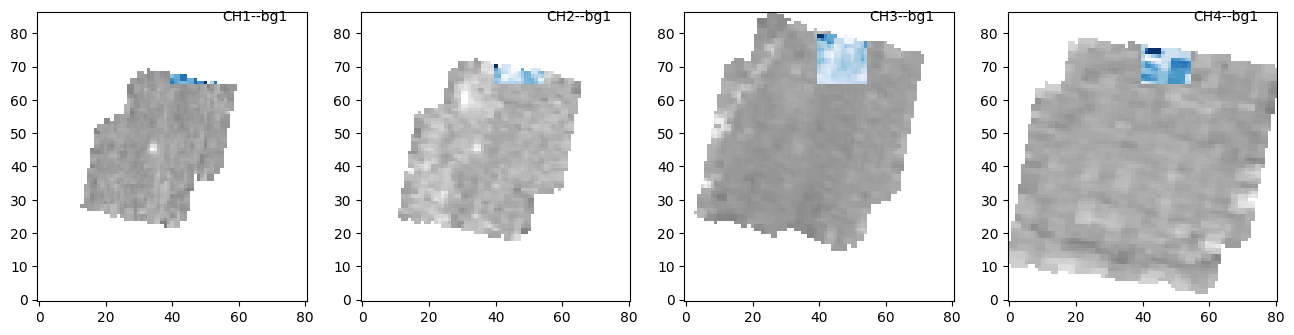

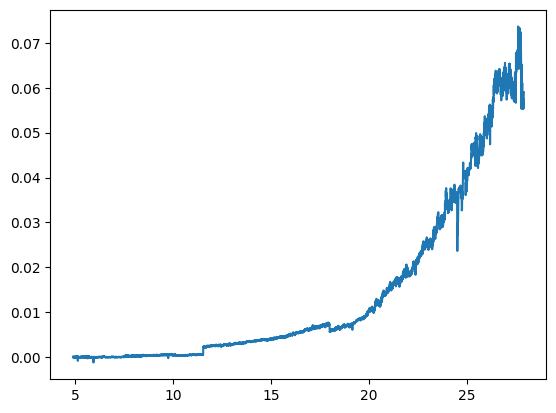

2023-07-31 14:26:08,289 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2023-07-31 14:26:11,548 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<IFUCubeModel(10324, 87, 81) from 2022acko_EXTENDED_ch1-2-3-4-shortmediumlong_s3d.fits>,).
2023-07-31 14:26:11,549 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/mshahbandeh/Documents/bg2_y(70,85)_z(46-61)_BS.fits', 'output_dir': '/Users/mshahbandeh/JWST/2122/2022acko/stage3/bgs/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': False, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'soss_atoca': True, 'soss_threshold':

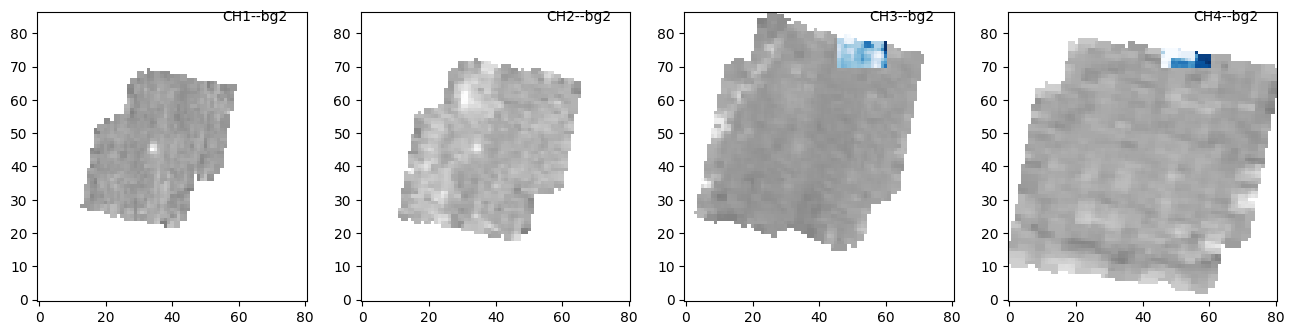

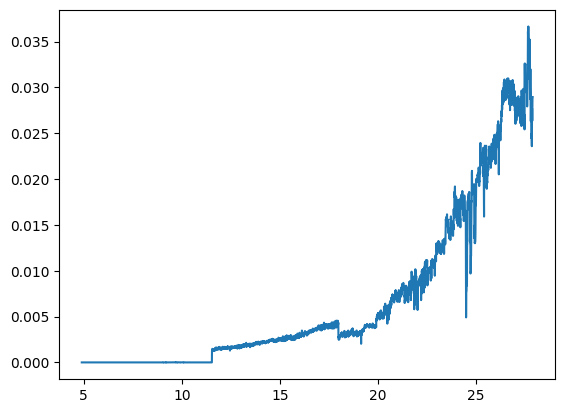

2023-07-31 14:27:38,438 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2023-07-31 14:27:41,697 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<IFUCubeModel(10324, 87, 81) from 2022acko_EXTENDED_ch1-2-3-4-shortmediumlong_s3d.fits>,).
2023-07-31 14:27:41,699 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/mshahbandeh/Documents/bg3_y(57,72)_z(20-35)_BS.fits', 'output_dir': '/Users/mshahbandeh/JWST/2122/2022acko/stage3/bgs/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': False, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'soss_atoca': True, 'soss_threshold':

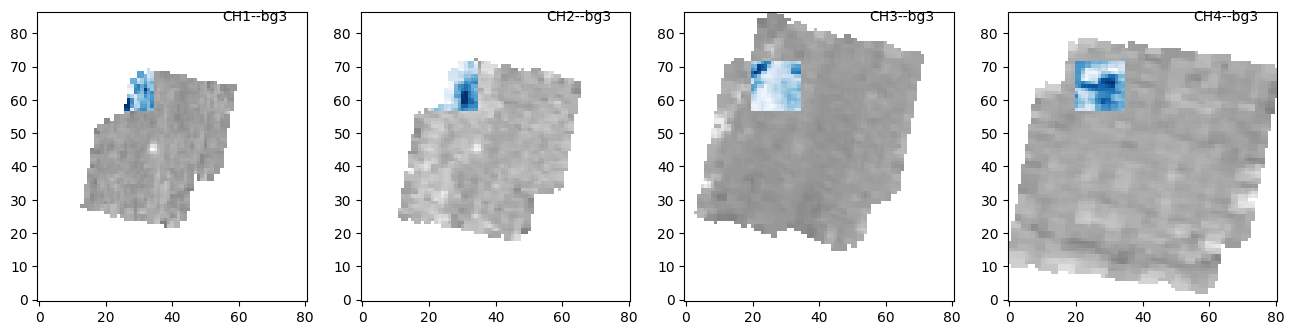

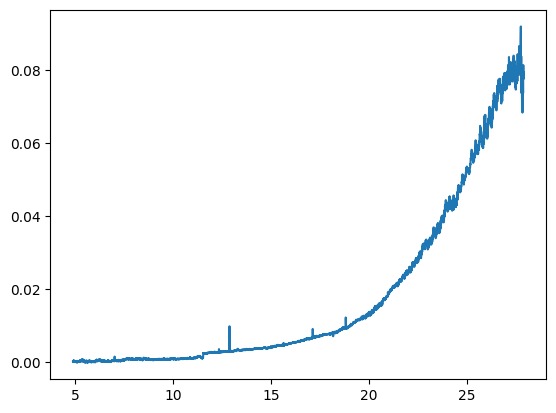

2023-07-31 14:29:44,374 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2023-07-31 14:29:47,606 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<IFUCubeModel(10324, 87, 81) from 2022acko_EXTENDED_ch1-2-3-4-shortmediumlong_s3d.fits>,).
2023-07-31 14:29:47,608 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/mshahbandeh/Documents/bg4_y(35,50)_z(50-65)_BS.fits', 'output_dir': '/Users/mshahbandeh/JWST/2122/2022acko/stage3/bgs/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': False, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'soss_atoca': True, 'soss_threshold':

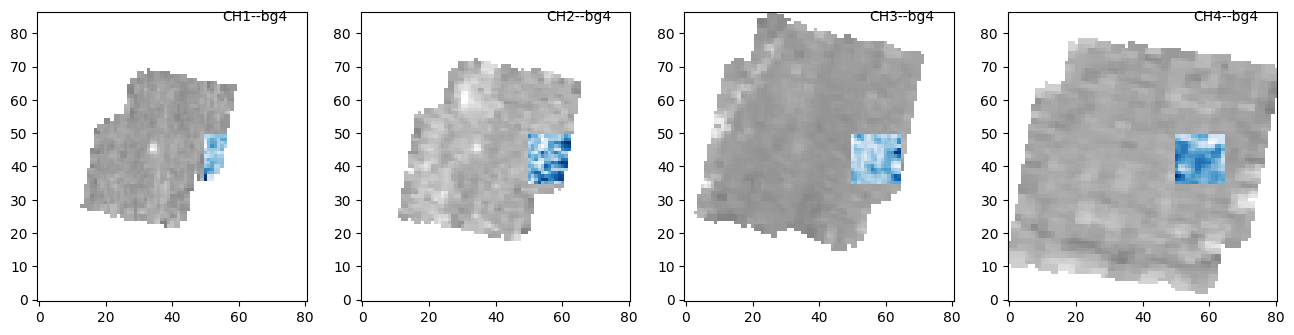

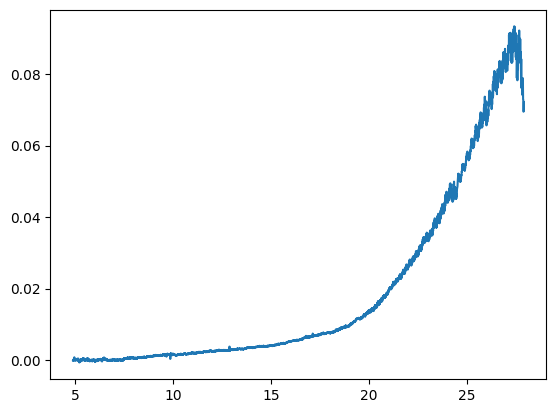

2023-07-31 14:31:50,290 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2023-07-31 14:31:53,548 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<IFUCubeModel(10324, 87, 81) from 2022acko_EXTENDED_ch1-2-3-4-shortmediumlong_s3d.fits>,).
2023-07-31 14:31:53,550 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/mshahbandeh/Documents/bg5_y(30,45)_z(26-41)_BS.fits', 'output_dir': '/Users/mshahbandeh/JWST/2122/2022acko/stage3/bgs/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': False, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'soss_atoca': True, 'soss_threshold':

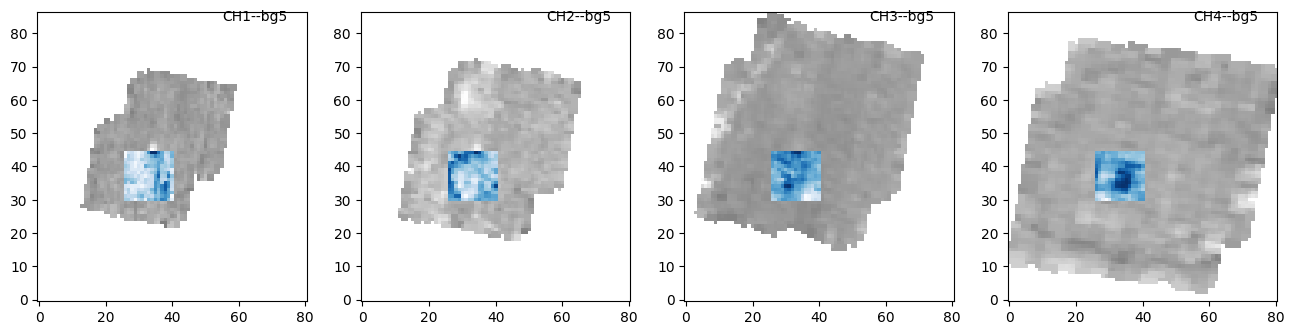

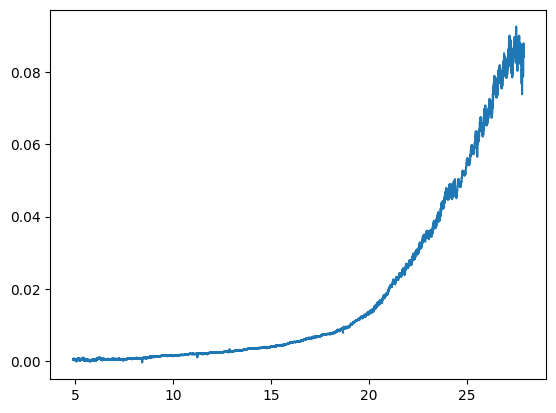

2023-07-31 14:33:57,837 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2023-07-31 14:34:01,172 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<IFUCubeModel(10324, 87, 81) from 2022acko_EXTENDED_ch1-2-3-4-shortmediumlong_s3d.fits>,).
2023-07-31 14:34:01,174 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/mshahbandeh/Documents/bg6_y(55,70)_z(35-50)_BS.fits', 'output_dir': '/Users/mshahbandeh/JWST/2122/2022acko/stage3/bgs/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': False, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'soss_atoca': True, 'soss_threshold':

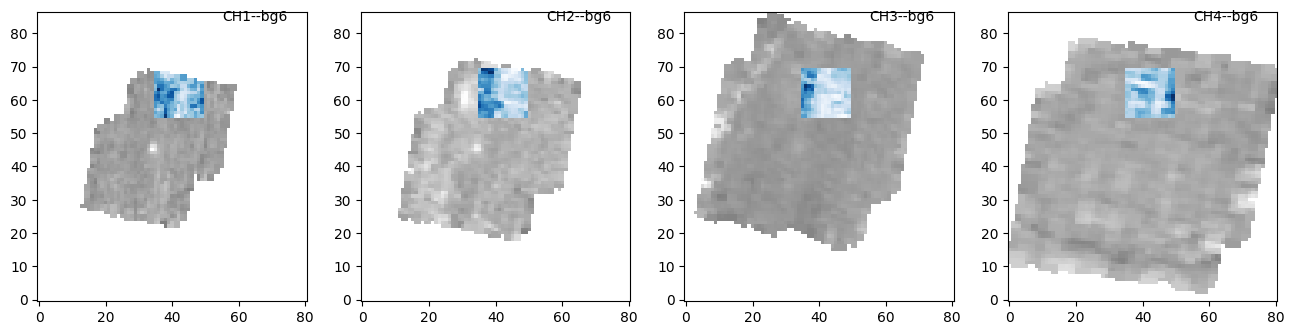

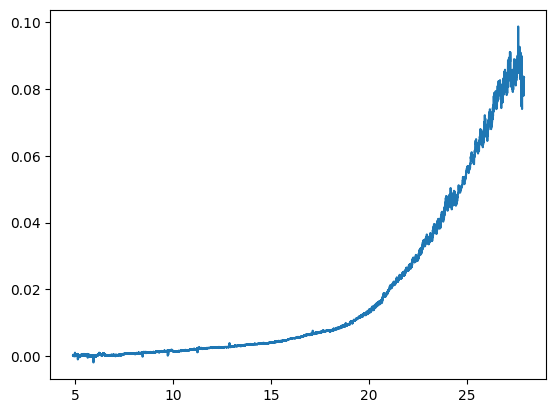

2023-07-31 14:36:06,418 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2023-07-31 14:36:10,877 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<IFUCubeModel(10324, 87, 81) from 2022acko_EXTENDED_ch1-2-3-4-shortmediumlong_s3d.fits>,).
2023-07-31 14:36:10,879 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/mshahbandeh/Documents/bg7_y(15,30)_z(20-35)_BS.fits', 'output_dir': '/Users/mshahbandeh/JWST/2122/2022acko/stage3/bgs/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': False, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'soss_atoca': True, 'soss_threshold':

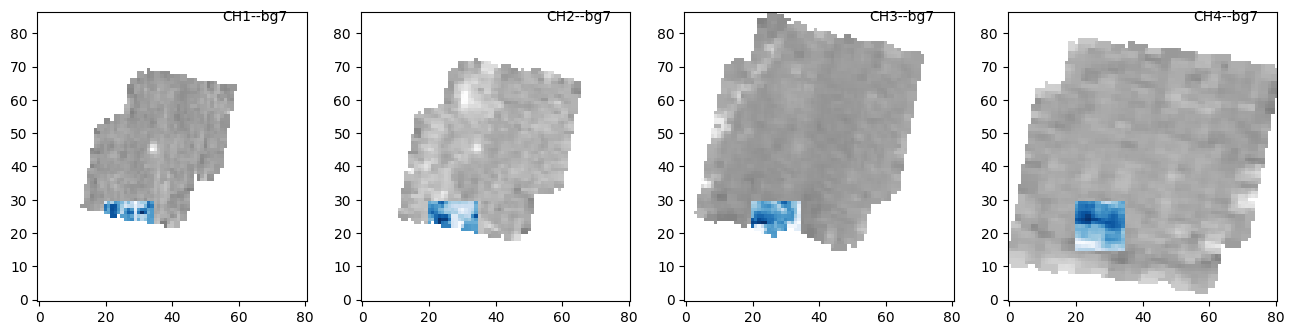

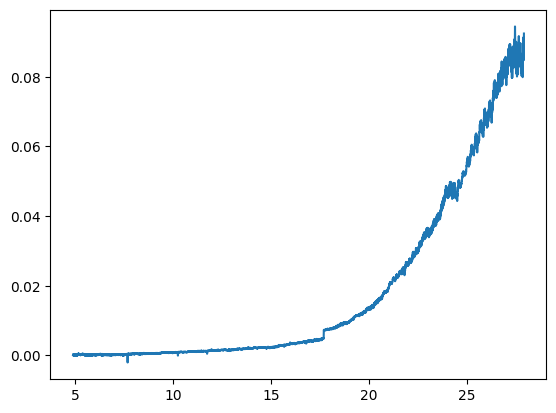

2023-07-31 14:38:14,759 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2023-07-31 14:38:18,343 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<IFUCubeModel(10324, 87, 81) from 2022acko_EXTENDED_ch1-2-3-4-shortmediumlong_s3d.fits>,).
2023-07-31 14:38:18,345 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/mshahbandeh/Documents/bg8_y(30,45)_z(40-55)_BS.fits', 'output_dir': '/Users/mshahbandeh/JWST/2122/2022acko/stage3/bgs/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': False, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'soss_atoca': True, 'soss_threshold':

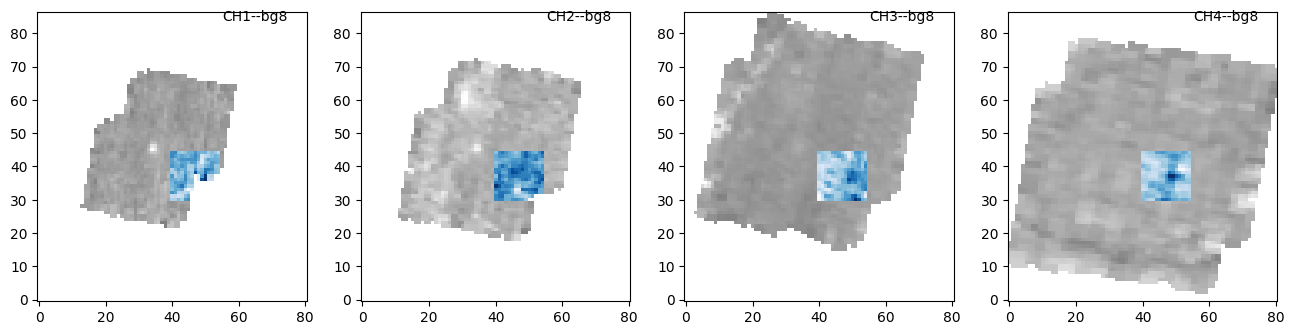

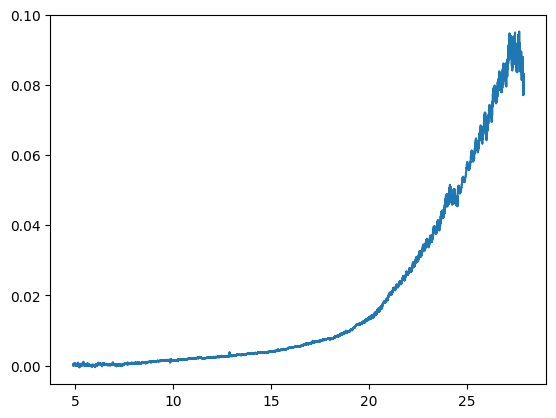

2023-07-31 14:40:22,517 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2023-07-31 14:40:27,080 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<IFUCubeModel(10324, 87, 81) from 2022acko_EXTENDED_ch1-2-3-4-shortmediumlong_s3d.fits>,).
2023-07-31 14:40:27,081 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/mshahbandeh/Documents/bg9_y(25,40)_z(25-40)_BS.fits', 'output_dir': '/Users/mshahbandeh/JWST/2122/2022acko/stage3/bgs/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': False, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'soss_atoca': True, 'soss_threshold':

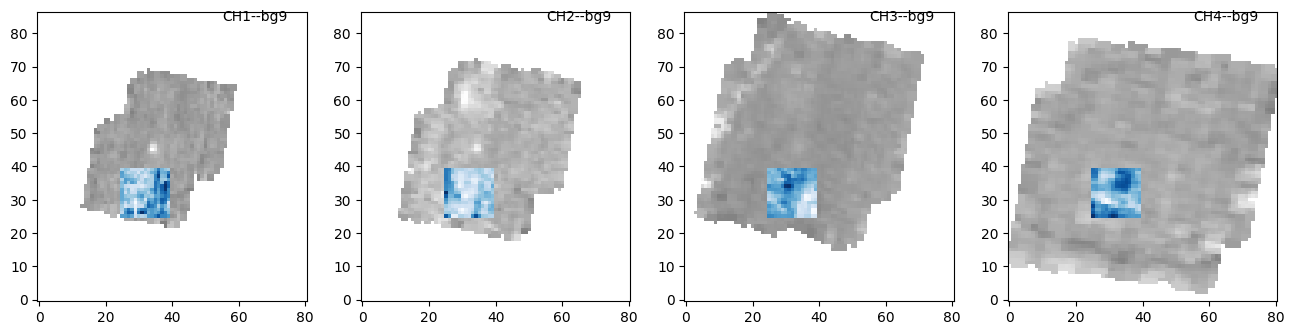

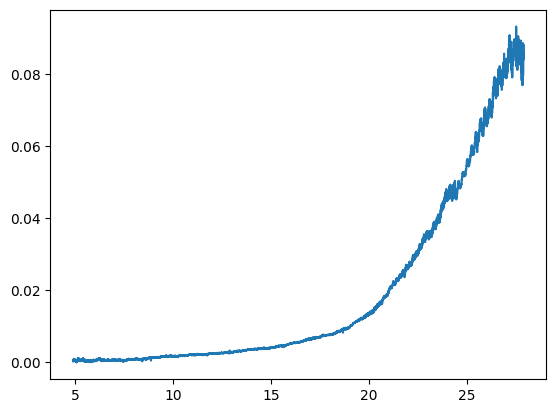

2023-07-31 14:42:30,366 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2023-07-31 14:42:33,919 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<IFUCubeModel(10324, 87, 81) from 2022acko_EXTENDED_ch1-2-3-4-shortmediumlong_s3d.fits>,).
2023-07-31 14:42:33,921 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/mshahbandeh/Documents/bg10_y(22,37)_z(18-33)_BS.fits', 'output_dir': '/Users/mshahbandeh/JWST/2122/2022acko/stage3/bgs/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': False, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'soss_atoca': True, 'soss_threshold'

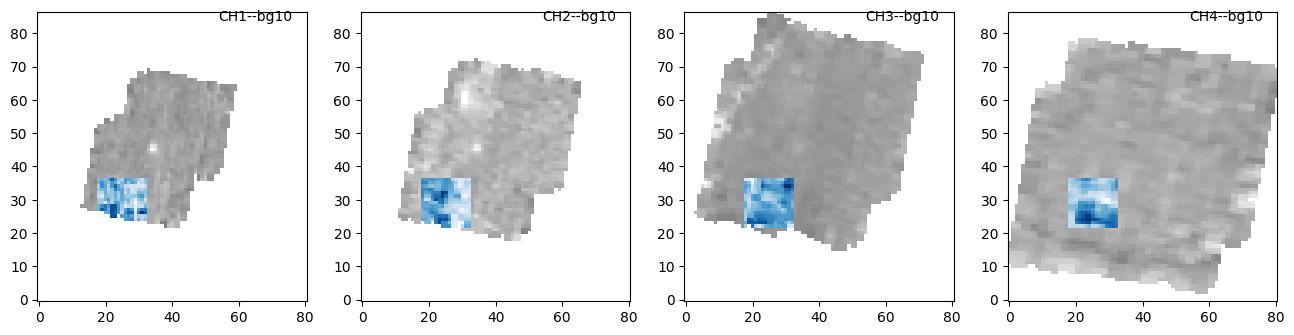

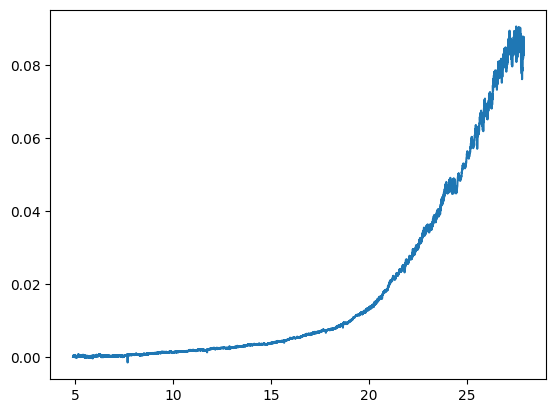

2023-07-31 14:44:36,751 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2023-07-31 14:44:39,976 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<IFUCubeModel(10324, 87, 81) from 2022acko_EXTENDED_ch1-2-3-4-shortmediumlong_s3d.fits>,).
2023-07-31 14:44:39,977 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/mshahbandeh/Documents/bg11_y(20,35)_z(40-55)_BS.fits', 'output_dir': '/Users/mshahbandeh/JWST/2122/2022acko/stage3/bgs/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': False, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'soss_atoca': True, 'soss_threshold'

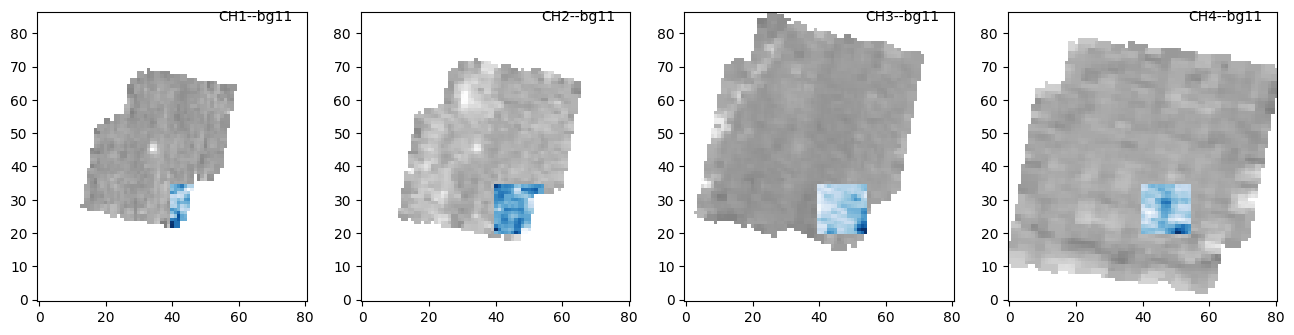

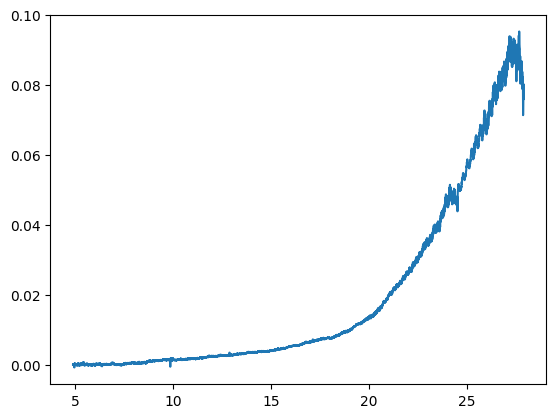

2023-07-31 14:46:42,365 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2023-07-31 14:46:45,968 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<IFUCubeModel(10324, 87, 81) from 2022acko_EXTENDED_ch1-2-3-4-shortmediumlong_s3d.fits>,).
2023-07-31 14:46:45,969 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/mshahbandeh/Documents/bg12_y(40,55)_z(60-75)_BS.fits', 'output_dir': '/Users/mshahbandeh/JWST/2122/2022acko/stage3/bgs/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': False, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'soss_atoca': True, 'soss_threshold'

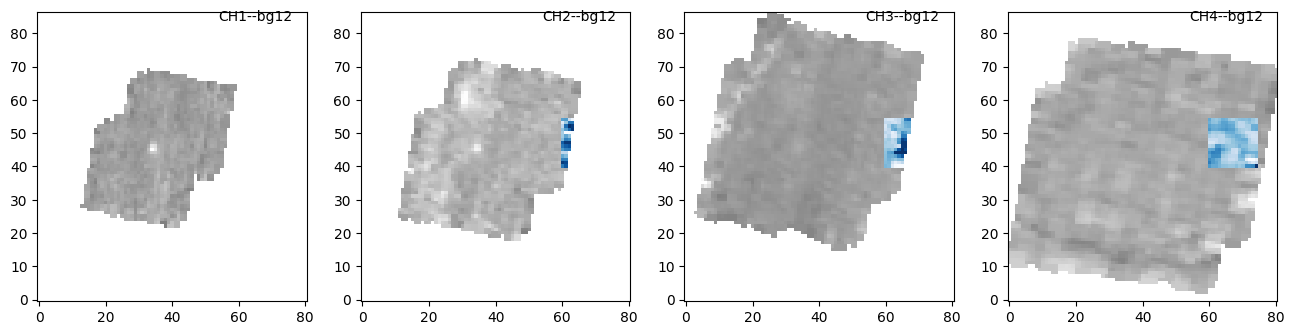

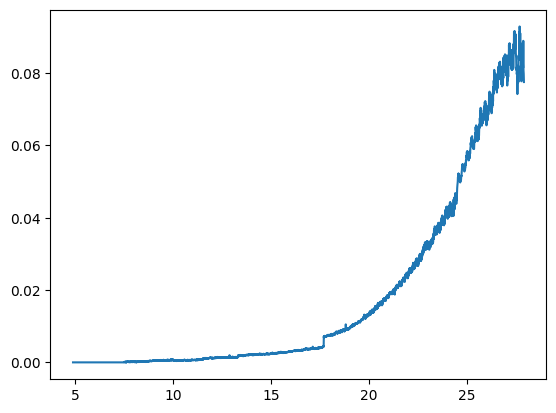

2023-07-31 14:48:28,344 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2023-07-31 14:48:31,850 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<IFUCubeModel(10324, 87, 81) from 2022acko_EXTENDED_ch1-2-3-4-shortmediumlong_s3d.fits>,).
2023-07-31 14:48:31,852 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/mshahbandeh/Documents/bg13_y(30,45)_z(10-25)_BS.fits', 'output_dir': '/Users/mshahbandeh/JWST/2122/2022acko/stage3/bgs/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': False, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'soss_atoca': True, 'soss_threshold'

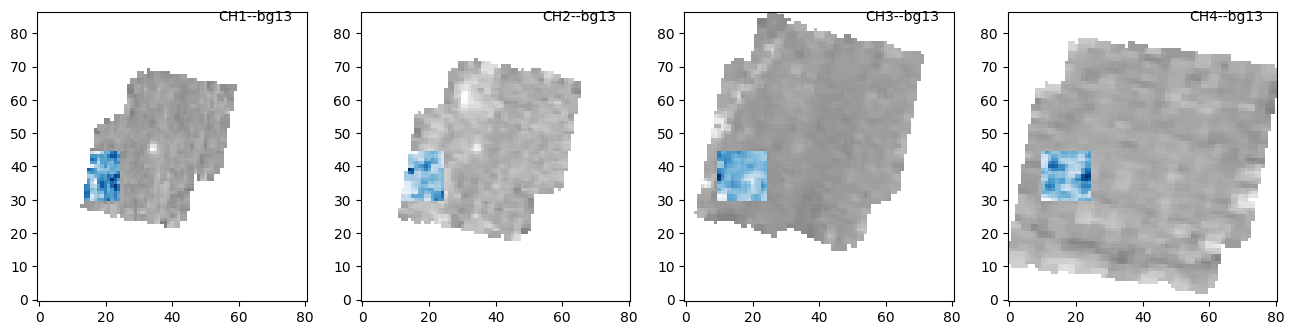

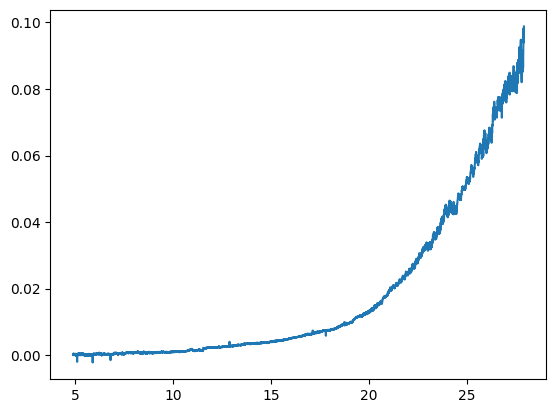

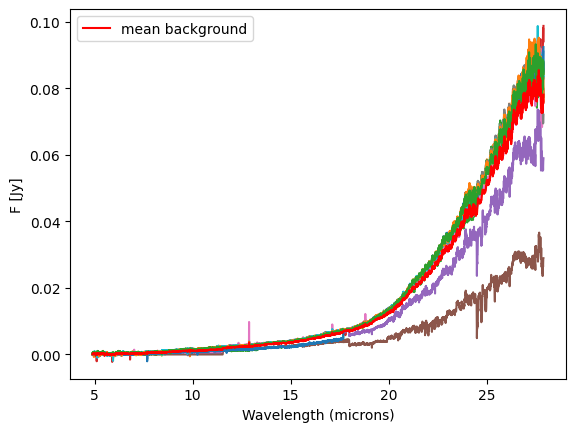

In [72]:
# Defining where the regions start, y is the horizontal, and z is the vertical axes
filters = {
    'bg1': {'y': (40,45), 'z': (65,70)},
    'bg2': {'y': (46,52), 'z': (70,73)},
    'bg3': {'y': (20,26), 'z': (57,60)},
    'bg4': {'y': (50,55), 'z': (35,40)},
    'bg5': {'y': (26,31), 'z': (30,39)},
    'bg6': {'y': (35,40), 'z': (55,60)},
    'bg7': {'y': (20,30), 'z': (15,20)},
    'bg8': {'y': (40,50), 'z': (30,40)},
    'bg9': {'y': (25,30), 'z': (25,30)},
    'bg10': {'y': (18,30), 'z': (22,38)},
    'bg11': {'y': (40,60), 'z': (20,40)},
    'bg12': {'y': (60,70), 'z': (40,60)},
    'bg13': {'y': (10,70), 'z': (30,60)},
}

Ch_edges=[0,3279,6226,8608]

# Width of the background regions, so wd=10 is 10by10 square, adjust accordingly if your cube is much bigger or smaller
wd=15

for key,region in filters.items():
    # Python reads x,y pixels as y,x, so we switch them
    z_range = region['y']
    y_range = region['z']
    spec_model_cube = IFUCubeModel()
    spec_model_cube.read(spec3_dir+f'{SN}_EXTENDED_ch1-2-3-4-shortmediumlong_s3d.fits')
    nan_mask = np.ones((x_dim,y_dim,z_dim))*np.nan
    zero_mask = np.zeros((x_dim,y_dim,z_dim))

    # Checking to see if the background regions look ok and do not cover the target (if so change the wd)
    fig1, axes = plt.subplots(nrows=1,ncols=4,figsize=(16,4))
    for i in range(len(Ch_edges)):
        nan_mask[Ch_edges[i]+400, y_range[0]:y_range[0]+wd, z_range[0]:z_range[0]+wd]=spec_model_cube.data[Ch_edges[i]+400, y_range[0]:y_range[0]+wd, z_range[0]:z_range[0]+wd]
        axes[i].imshow(spec_model_cube.data[Ch_edges[i]+400, :, :], origin='lower', cmap='gray',alpha=0.5)
        axes[i].imshow(nan_mask[Ch_edges[i]+400, :, :], origin='lower', cmap='Blues',alpha=1)
        axes[i].text(65, 85, 'CH'+str(i+1)+'--'+key, fontsize=10, ha='center', va='center')
        
    # Mask everything but the backgrounds
    for x in range(x_dim):
        zero_mask[x, y_range[0]:y_range[0]+wd, z_range[0]:z_range[0]+wd]=spec_model_cube.weightmap[x, y_range[0]:y_range[0]+wd, z_range[0]:z_range[0]+wd]
        
    spec_model_cube.weightmap=zero_mask

    runex(spec_model_cube, bg_dir, outputfile=f'{key}_y({y_range[0]},{y_range[0]+wd})_z({z_range[0]}-{z_range[0]+wd})_BS.fits')
    
    try:
        fig2, axes = plt.subplots()
        spec=fits.open(bg_dir+f'{key}_y({y_range[0]},{y_range[0]+wd})_z({z_range[0]}-{z_range[0]+wd})_BS_extract1dstep.fits')
        wave, flux = spec[1].data['WAVELENGTH'], spec[1].data['FLUX']
        plt.plot(wave, flux)
        plt.show()
    except:
        continue

### 4.3<font color='white'>-</font>Averaging the background spectra to get the master background and then plot them<a class="anchor" id=" Averaging the background spectra to get the master background and then plot them"></a>

In [ ]:
# Averaging them
sstring = bg_dir + 'bg*y*_BS_extract1dstep.fits'
bgfiles = sorted(glob.glob(sstring))
mean_FL, mean_SB, mean_BK = SBM(bgfiles)

# Creating the mean/master background
hdu = fits.open(bgfiles[0])
fl = np.zeros(len(hdu[1].data))
otab = np.array(list(zip(hdu[1].data['wavelength'], *([fl] * 17))), dtype=datamodels.SpecModel().spec_table.dtype)
model = datamodels.SpecModel(spec_table=otab)
model.spec_table['FLUX'], model.spec_table['SURF_BRIGHT'] = mean_FL, mean_SB
multimod = datamodels.MultiSpecModel()
multimod.spec.append(model)
multimod.save(bg_dir + f'mean_bg_{wd}X{wd}pix_BS.fits')

# Plotting all bgs again plus the mean bg
for i in range(len(bgfiles)):
    spec=fits.open(bgfiles[i])
    wave, flux = spec[1].data['WAVELENGTH'], spec[1].data['FLUX']
    plt.plot(wave, flux)
    
spec=fits.open(bg_dir + f'mean_bg_{wd}X{wd}pix_BS.fits')
wave, flux = spec[1].data['WAVELENGTH'], spec[1].data['FLUX']
plt.plot(wave,flux, label='mean background',color='red')

plt.xlabel('Wavelength (microns)')
plt.ylabel('F [Jy]')
plt.legend()
plt.savefig(bg_dir + 'all_bg_and_mean_BS.pdf')
plt.show()

### 4.4<font color='white'>-</font> Create background subtracted cube<a class="anchor" id="Create background subtracted cube"></a>

In [73]:
def writel3asn(scifiles, bgfiles, asnfile, prodname):
   # Define the basic association of science files
    asn = afl.asn_from_list(scifiles, rule=DMS_Level3_Base, product_name=prodname)

   # Add background files to the association
    nbg=len(bgfiles)
    for ii in range(0,nbg):
        asn['products'][0]['members'].append({'expname': bgfiles[ii], 'exptype': 'background'})

   # Write the association to a json file
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)

sstring = spec2_dir + 'jw*mirifu*rate*cal.fits'
calfiles = np.array(sorted(glob.glob(sstring)))

bgfiles = bg_dir + f'mean_bg_{wd}X{wd}pix_BS.fits'

print('Found ' + str(len(calfiles)) + ' science files to process')
print('Found ' + str(len(bgfiles)) + ' background files to process')

asnfile=os.path.join(output_dir, 'asn_file_subtracted.json')
if dospec3:
    writel3asn(calfiles, bgfiles, asnfile, 'Level3')
    
########################################################################

def runspec3(filename, nocubes=True):
    crds_config = Spec3Pipeline.get_config_from_reference(filename)
    spec3 = Spec3Pipeline.from_config_section(crds_config)
    spec3.output_dir = spec3_dir
    spec3.save_results = True
    spec3.cube_build.output_type = 'multi' # 'band', 'channel', or 'multi' type cube output
    spec3.master_background.skip = False
    spec3.master_background.save_background=False
    spec3.master_background.save_results=False
    spec3.master_background.user_background= bg_dir + f'mean_bg_{wd}X{wd}pix_BS.fits' # The mean background we built earlier
    spec3.master_background.force_subtract=True
    spec3.outlier_detection.skip = False
    spec3.outlier_detection.kernel_size = '11 1'
    spec3.outlier_detection.threshold_percent = 99.8
    spec3.mrs_imatch.skip = True
    spec3.extract_1d.subtract_background=False
    spec3.extract_1d.use_source_posn = True
    spec3.extract_1d.center_xy = (xcen,ycen) # Override aperture location if desired using the brightest source we found earlier
    spec3.extract_1d.ifu_rfcorr = True # Turn on 1d residual fringe correction
    spec3.cube_build.output_file = f'{SN}_subtracted_{wd}X{wd}pix'
    spec3(filename)
    
if dospec3:
    runspec3(asnfile,nocubes=False)
else:
    print('Skipping Spec3 processing')

['/Users/mshahbandeh/JWST/2122/2022acko/stage3/bgs/mean_bg_15X15pix_BS.fits']
Found 24 science files to process
Found 1 background files to process


2023-07-31 14:50:35,165 - stpipe - INFO - PARS-OUTLIERDETECTIONSTEP parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-outlierdetectionstep_0051.asdf
2023-07-31 14:50:35,215 - stpipe - INFO - PARS-SPEC3PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-spec3pipeline_0004.asdf
2023-07-31 14:50:35,236 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2023-07-31 14:50:35,236 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2023-07-31 14:50:35,237 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.
2023-07-31 14:50:35,238 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.
2023-07-31 14:50:35,239 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2023-07-31 14:50:35,240 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.
2023-07-31 14:50:35,241 - stpipe.Spec3Pipeline.cube_build - INFO 

### 4.5<font color='white'>-</font>Let's take a look at the subtracted cube<a class="anchor" id="Let's take a look at the subtracted cube"></a>

In [74]:
cubeviz = Cubeviz()
cubeviz.load_data(spec3_dir+f'{SN}_subtracted_{wd}X{wd}pix_ch1-2-3-4-shortmediumlong_s3d.fits')
cubeviz.app

Application(config='cubeviz', events=['call_viewer_method', 'close_snackbar_message', 'data_item_remove', 'dat…

5.<font color='white'>-</font>Residual backgrounds<a class="anchor" id="Residual backgrounds"></a>
------------------

### 5.1<font color='white'>-</font>Changing the source type<a class="anchor" id="Changing the source type"></a>

In [75]:
#changing source type
spec_model_cube = IFUCubeModel()
spec_model_cube.read(spec3_dir+f'{SN}_subtracted_{wd}X{wd}pix_ch1-2-3-4-shortmediumlong_s3d.fits')
spec_model_cube.meta.target.source_type = 'EXTENDED'
spec_model_cube.save(spec3_dir+f'{SN}_EXTENDED_subtracted_{wd}X{wd}pix_ch1-2-3-4-shortmediumlong_s3d.fits')

'/Users/mshahbandeh/JWST/2122/2022acko/stage3/2022acko_EXTENDED_subtracted_15X15pix_ch1-2-3-4-shortmediumlong_s3d.fits'

### 5.2<font color='white'>-</font>Extract residual backgrounds from the subtracted cube<a class="anchor" id="Extract residual backgrounds from the subtracted cube"></a>

2023-07-31 15:08:49,789 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2023-07-31 15:08:55,662 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<IFUCubeModel(10324, 87, 81) from 2022acko_EXTENDED_subtracted_15X15pix_ch1-2-3-4-shortmediumlong_s3d.fits>,).
2023-07-31 15:08:55,664 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/mshahbandeh/Documents/bg1_y(65,80)_z(40-55)_AS.fits', 'output_dir': '/Users/mshahbandeh/JWST/2122/2022acko/stage3/bgs/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': False, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'soss_atoca': Tru

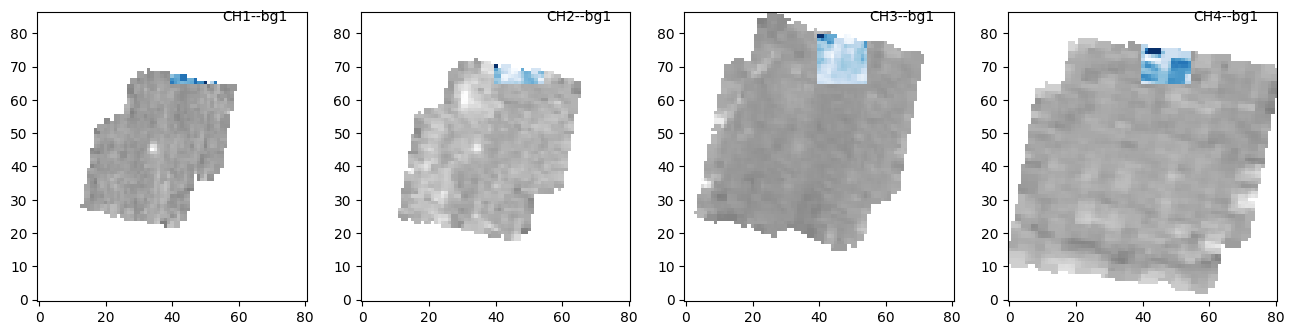

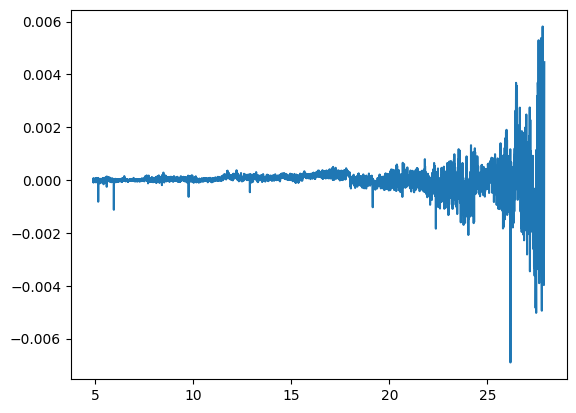

2023-07-31 15:10:59,238 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2023-07-31 15:11:03,361 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<IFUCubeModel(10324, 87, 81) from 2022acko_EXTENDED_subtracted_15X15pix_ch1-2-3-4-shortmediumlong_s3d.fits>,).
2023-07-31 15:11:03,363 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/mshahbandeh/Documents/bg2_y(70,85)_z(46-61)_AS.fits', 'output_dir': '/Users/mshahbandeh/JWST/2122/2022acko/stage3/bgs/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': False, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'soss_atoca': Tru

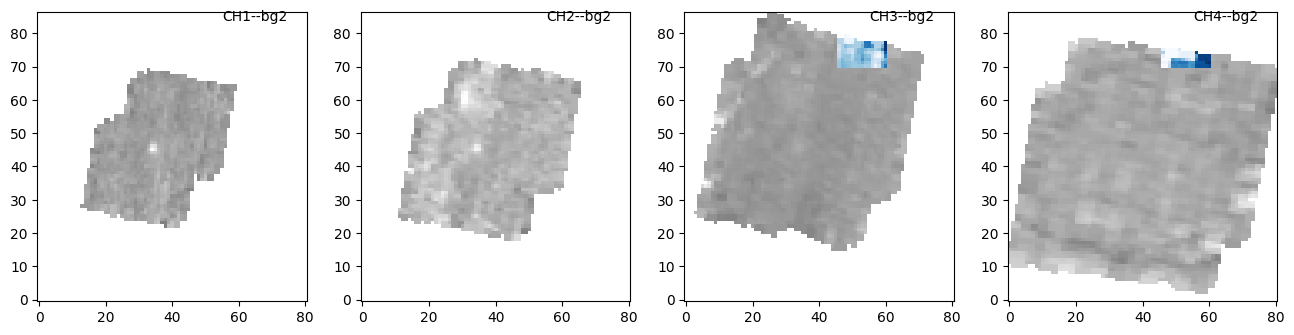

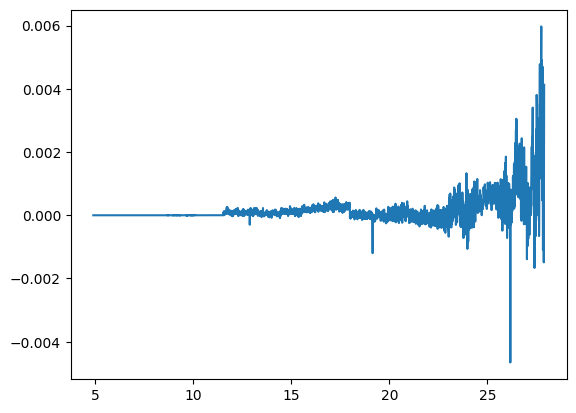

2023-07-31 15:12:34,821 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2023-07-31 15:12:39,099 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<IFUCubeModel(10324, 87, 81) from 2022acko_EXTENDED_subtracted_15X15pix_ch1-2-3-4-shortmediumlong_s3d.fits>,).
2023-07-31 15:12:39,101 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/mshahbandeh/Documents/bg3_y(57,72)_z(20-35)_AS.fits', 'output_dir': '/Users/mshahbandeh/JWST/2122/2022acko/stage3/bgs/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': False, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'soss_atoca': Tru

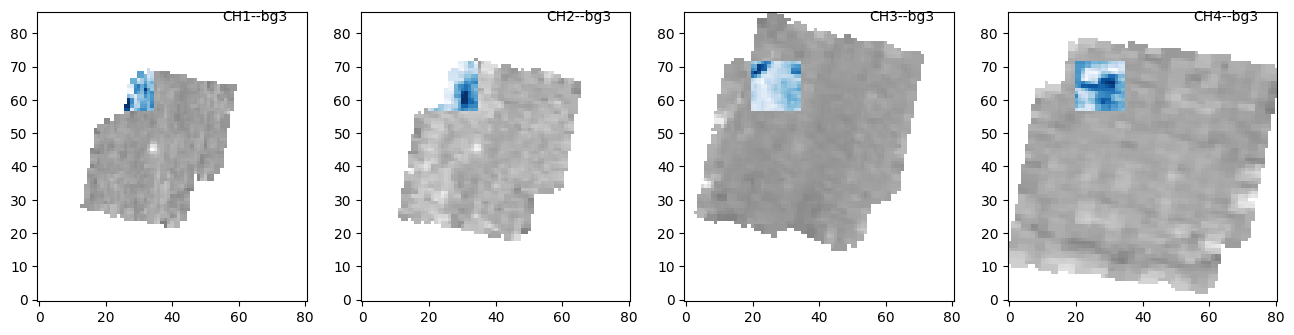

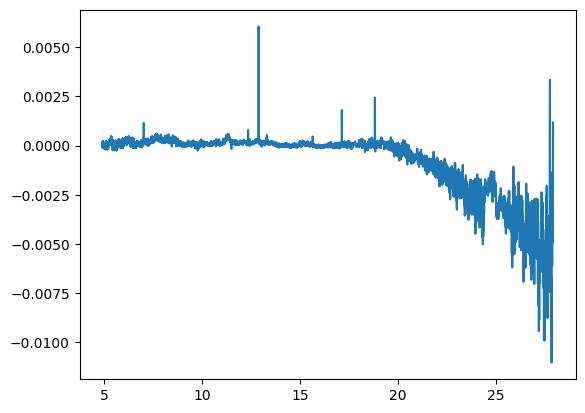

2023-07-31 15:14:48,711 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2023-07-31 15:14:53,611 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<IFUCubeModel(10324, 87, 81) from 2022acko_EXTENDED_subtracted_15X15pix_ch1-2-3-4-shortmediumlong_s3d.fits>,).
2023-07-31 15:14:53,612 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/mshahbandeh/Documents/bg4_y(35,50)_z(50-65)_AS.fits', 'output_dir': '/Users/mshahbandeh/JWST/2122/2022acko/stage3/bgs/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': False, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'soss_atoca': Tru

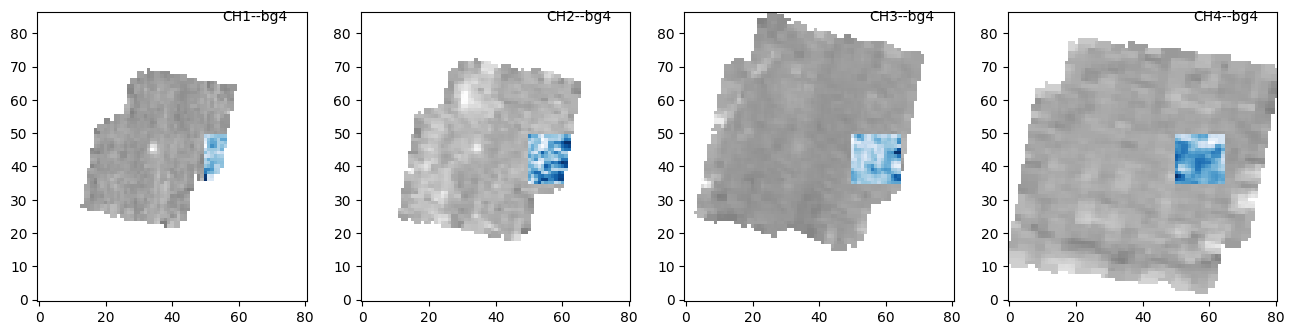

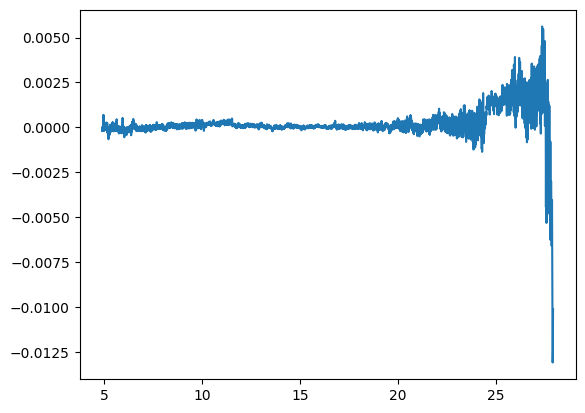

2023-07-31 15:17:02,477 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2023-07-31 15:17:06,652 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<IFUCubeModel(10324, 87, 81) from 2022acko_EXTENDED_subtracted_15X15pix_ch1-2-3-4-shortmediumlong_s3d.fits>,).
2023-07-31 15:17:06,653 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/mshahbandeh/Documents/bg5_y(30,45)_z(26-41)_AS.fits', 'output_dir': '/Users/mshahbandeh/JWST/2122/2022acko/stage3/bgs/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': False, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'soss_atoca': Tru

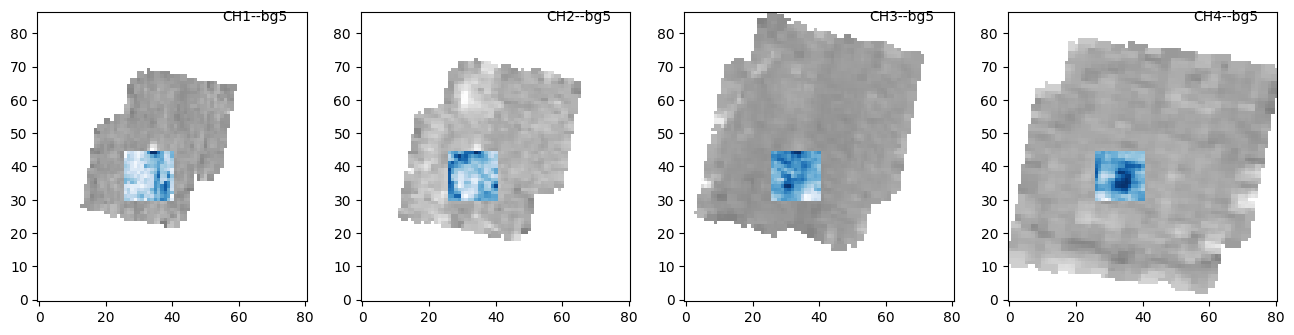

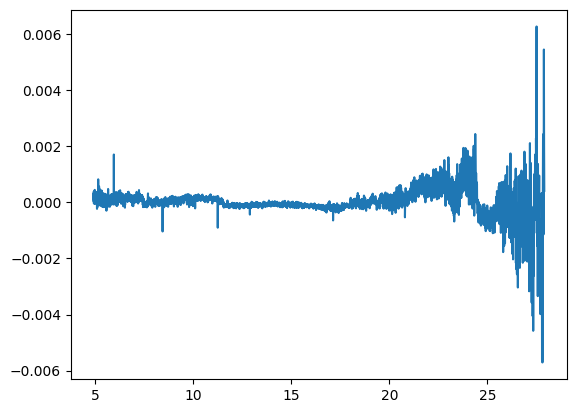

2023-07-31 15:19:47,004 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2023-07-31 15:19:52,162 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<IFUCubeModel(10324, 87, 81) from 2022acko_EXTENDED_subtracted_15X15pix_ch1-2-3-4-shortmediumlong_s3d.fits>,).
2023-07-31 15:19:52,164 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/mshahbandeh/Documents/bg6_y(55,70)_z(35-50)_AS.fits', 'output_dir': '/Users/mshahbandeh/JWST/2122/2022acko/stage3/bgs/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': False, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'soss_atoca': Tru

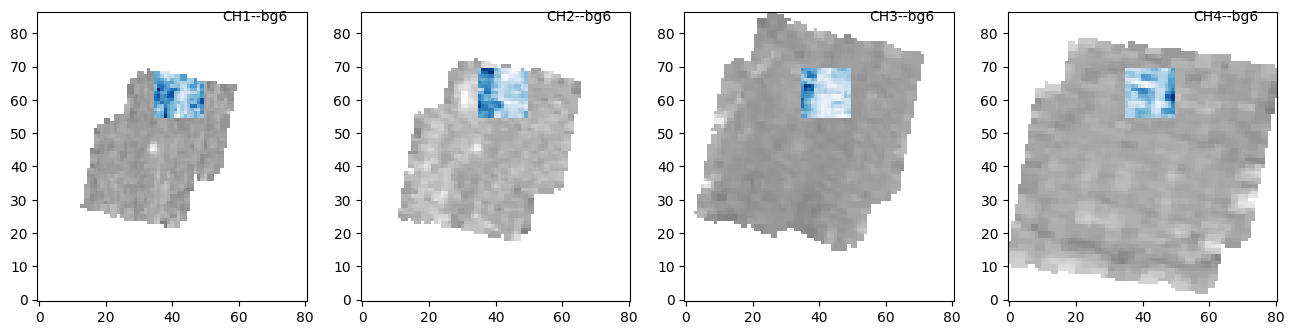

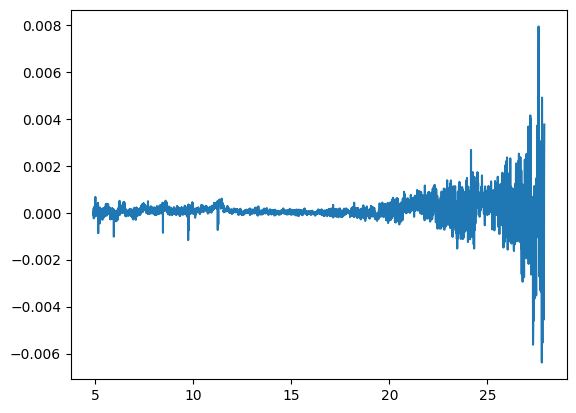

2023-07-31 15:26:57,426 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2023-07-31 15:28:11,649 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<IFUCubeModel(10324, 87, 81) from 2022acko_EXTENDED_subtracted_15X15pix_ch1-2-3-4-shortmediumlong_s3d.fits>,).
2023-07-31 15:28:11,651 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/mshahbandeh/Documents/bg7_y(15,30)_z(20-35)_AS.fits', 'output_dir': '/Users/mshahbandeh/JWST/2122/2022acko/stage3/bgs/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': False, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'soss_atoca': Tru

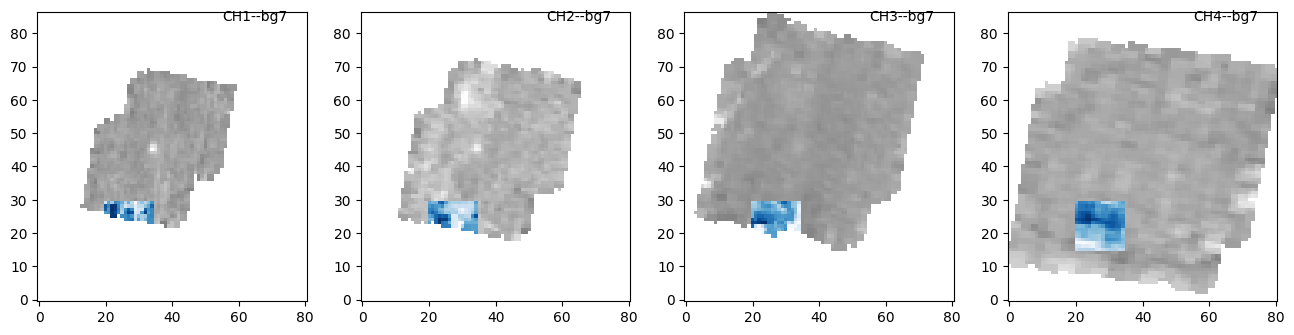

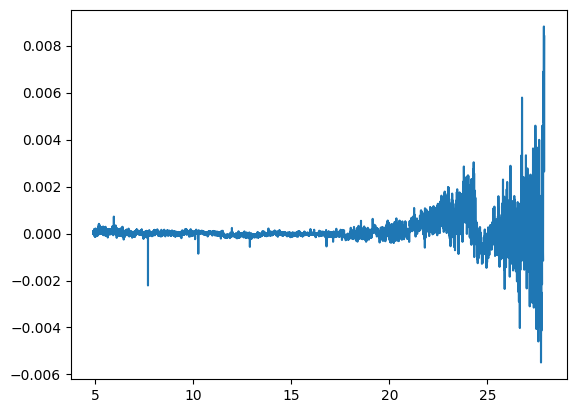

2023-07-31 15:30:19,930 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2023-07-31 15:30:24,194 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<IFUCubeModel(10324, 87, 81) from 2022acko_EXTENDED_subtracted_15X15pix_ch1-2-3-4-shortmediumlong_s3d.fits>,).
2023-07-31 15:30:24,196 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/mshahbandeh/Documents/bg8_y(30,45)_z(40-55)_AS.fits', 'output_dir': '/Users/mshahbandeh/JWST/2122/2022acko/stage3/bgs/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': False, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'soss_atoca': Tru

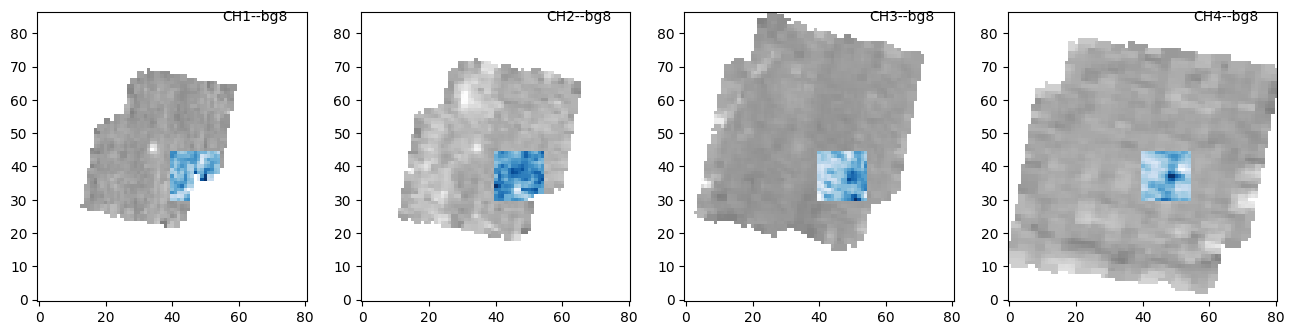

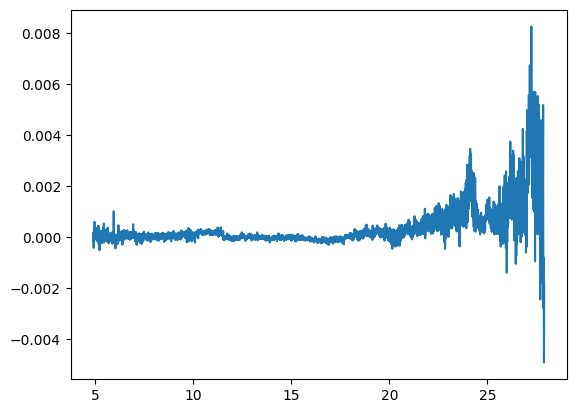

2023-07-31 15:32:31,230 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2023-07-31 15:32:35,409 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<IFUCubeModel(10324, 87, 81) from 2022acko_EXTENDED_subtracted_15X15pix_ch1-2-3-4-shortmediumlong_s3d.fits>,).
2023-07-31 15:32:35,410 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/mshahbandeh/Documents/bg9_y(25,40)_z(25-40)_AS.fits', 'output_dir': '/Users/mshahbandeh/JWST/2122/2022acko/stage3/bgs/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': False, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'soss_atoca': Tru

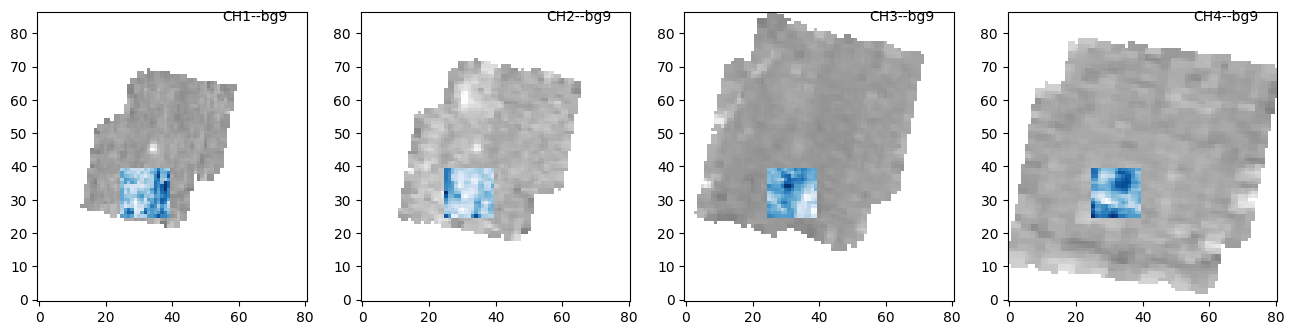

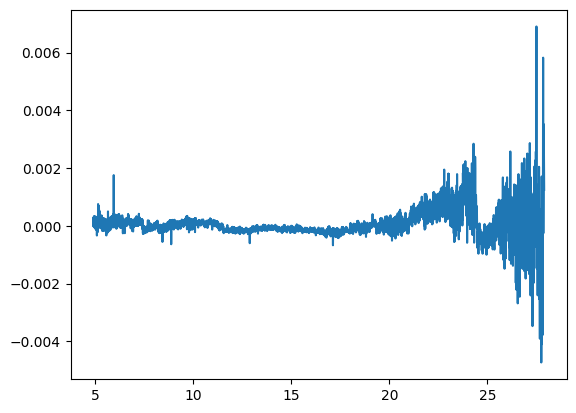

2023-07-31 15:34:43,267 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2023-07-31 15:34:47,489 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<IFUCubeModel(10324, 87, 81) from 2022acko_EXTENDED_subtracted_15X15pix_ch1-2-3-4-shortmediumlong_s3d.fits>,).
2023-07-31 15:34:47,491 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/mshahbandeh/Documents/bg10_y(22,37)_z(18-33)_AS.fits', 'output_dir': '/Users/mshahbandeh/JWST/2122/2022acko/stage3/bgs/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': False, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'soss_atoca': Tr

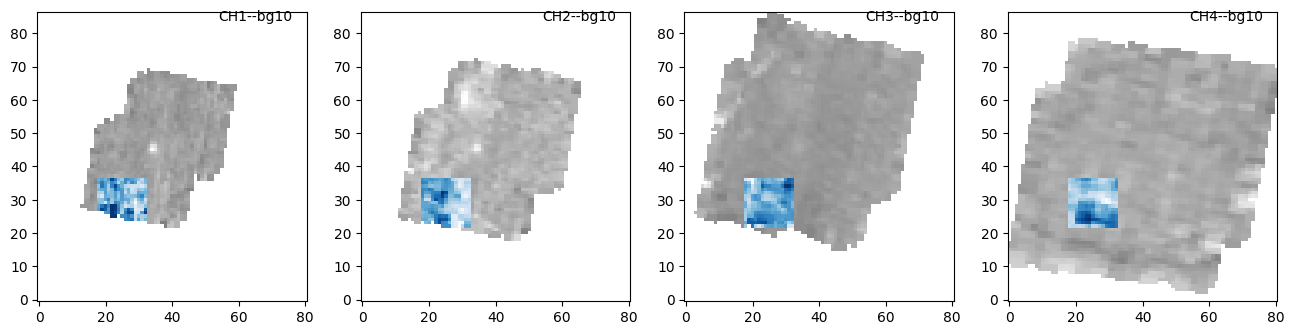

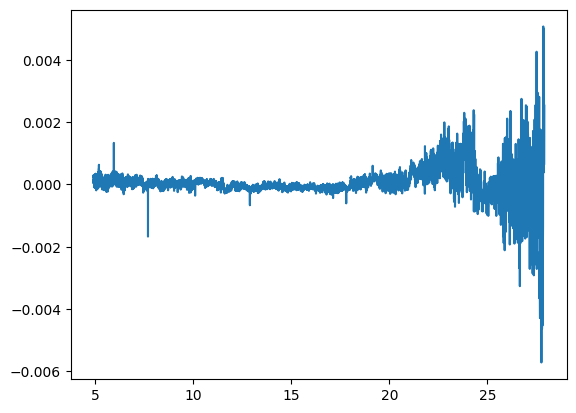

2023-07-31 15:37:12,749 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2023-07-31 15:37:16,955 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<IFUCubeModel(10324, 87, 81) from 2022acko_EXTENDED_subtracted_15X15pix_ch1-2-3-4-shortmediumlong_s3d.fits>,).
2023-07-31 15:37:16,957 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/mshahbandeh/Documents/bg11_y(20,35)_z(40-55)_AS.fits', 'output_dir': '/Users/mshahbandeh/JWST/2122/2022acko/stage3/bgs/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': False, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'soss_atoca': Tr

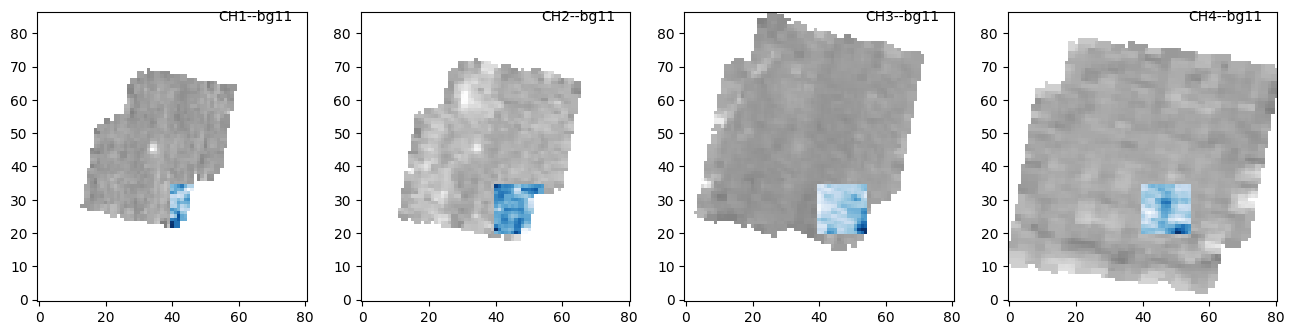

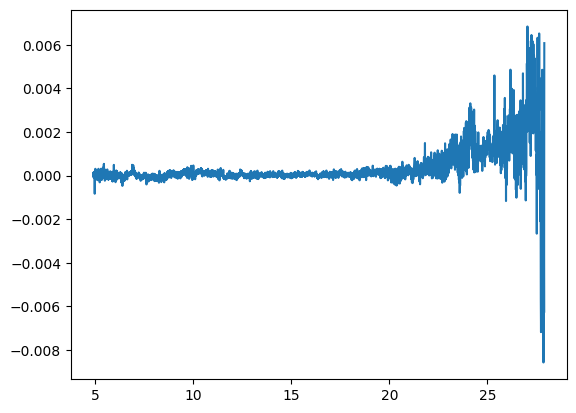

2023-07-31 15:39:37,548 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2023-07-31 15:39:41,903 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<IFUCubeModel(10324, 87, 81) from 2022acko_EXTENDED_subtracted_15X15pix_ch1-2-3-4-shortmediumlong_s3d.fits>,).
2023-07-31 15:39:41,905 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/mshahbandeh/Documents/bg12_y(40,55)_z(60-75)_AS.fits', 'output_dir': '/Users/mshahbandeh/JWST/2122/2022acko/stage3/bgs/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': False, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'soss_atoca': Tr

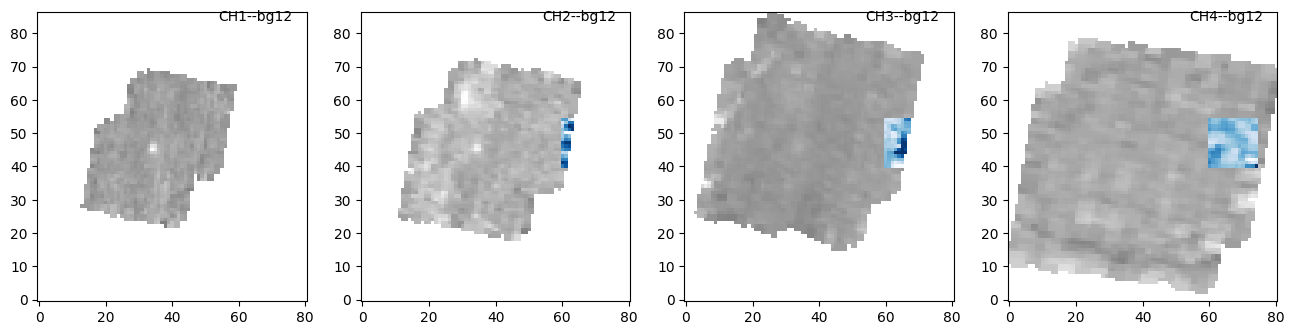

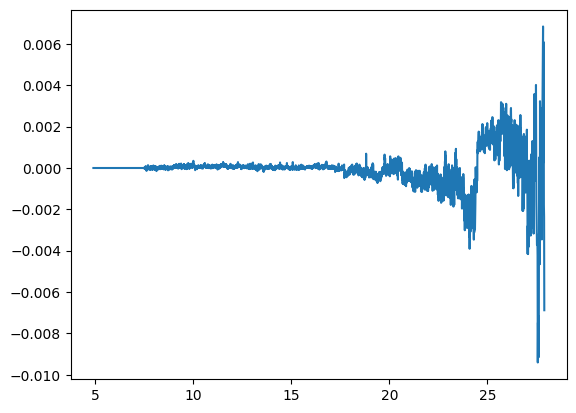

2023-07-31 15:41:28,055 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2023-07-31 15:41:32,168 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<IFUCubeModel(10324, 87, 81) from 2022acko_EXTENDED_subtracted_15X15pix_ch1-2-3-4-shortmediumlong_s3d.fits>,).
2023-07-31 15:41:32,169 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/mshahbandeh/Documents/bg13_y(30,45)_z(10-25)_AS.fits', 'output_dir': '/Users/mshahbandeh/JWST/2122/2022acko/stage3/bgs/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': False, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': False, 'ifu_rfcorr': False, 'soss_atoca': Tr

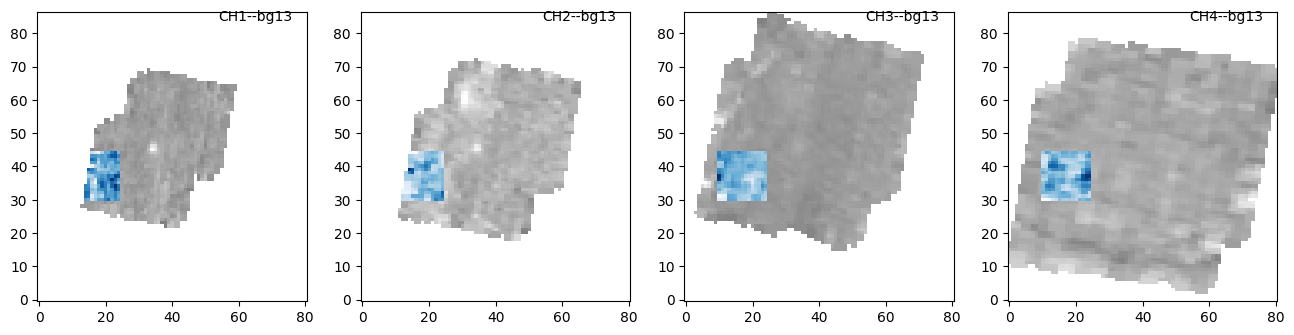

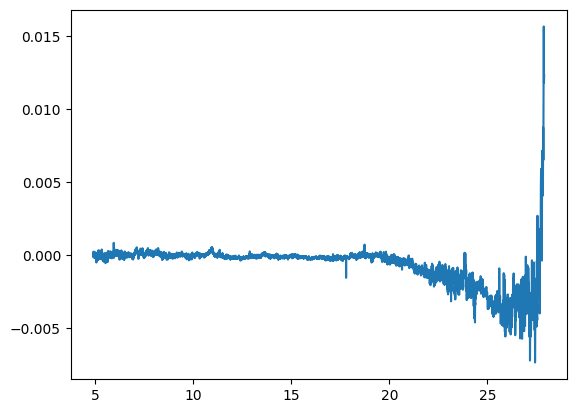

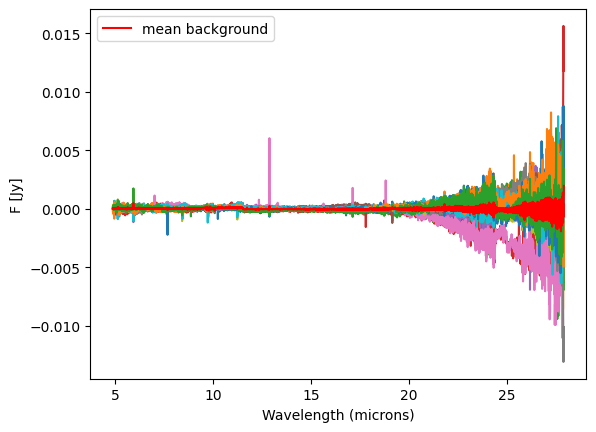

In [76]:
# Same as before but this time on subtracted cube
for key,region in filters.items():
    z_range = region['y']
    y_range = region['z']
    spec_model_cube = IFUCubeModel()
    spec_model_cube.read(spec3_dir+f'{SN}_EXTENDED_subtracted_{wd}X{wd}pix_ch1-2-3-4-shortmediumlong_s3d.fits')
    nan_mask = np.ones((x_dim,y_dim,z_dim))*np.nan
    zero_mask = np.zeros((x_dim,y_dim,z_dim))
    
    #checking background regions
    fig1, axes = plt.subplots(nrows=1,ncols=4,figsize=(16,4))
    for i in range(len(Ch_edges)):
        nan_mask[Ch_edges[i]+400, y_range[0]:y_range[0]+wd, z_range[0]:z_range[0]+wd]=spec_model_cube.data[Ch_edges[i]+400, y_range[0]:y_range[0]+wd, z_range[0]:z_range[0]+wd]
        axes[i].imshow(spec_model_cube.data[Ch_edges[i]+400, :, :], origin='lower', cmap='gray',alpha=0.5)
        axes[i].imshow(nan_mask[Ch_edges[i]+400, :, :], origin='lower', cmap='Blues',alpha=1)
        axes[i].text(65, 85, 'CH'+str(i+1)+'--'+key, fontsize=10, ha='center', va='center')

    for x in range(x_dim):
        zero_mask[x, y_range[0]:y_range[0]+wd, z_range[0]:z_range[0]+wd]=spec_model_cube.weightmap[x, y_range[0]:y_range[0]+wd, z_range[0]:z_range[0]+wd]
        
    spec_model_cube.weightmap=zero_mask

    runex(spec_model_cube, bg_dir, outputfile=f'{key}_y({y_range[0]},{y_range[0]+wd})_z({z_range[0]}-{z_range[0]+wd})_AS.fits')
    
    try:
        fig2, axes = plt.subplots()
        spec=fits.open(bg_dir+f'{key}_y({y_range[0]},{y_range[0]+wd})_z({z_range[0]}-{z_range[0]+wd})_AS_extract1dstep.fits')
        wave, flux = spec[1].data['WAVELENGTH'], spec[1].data['FLUX']
        plt.plot(wave, flux)
        plt.show()
    except:
        continue

### 5.3<font color='white'>-</font>Averaging the background spectra to get the mean residual background and then plot them<a class="anchor" id="Averaging the background spectra to get the mean residual background and then plot them"></a>

In [ ]:
sstring = bg_dir + 'bg*y*_AS_extract1dstep.fits'
bgfiles = sorted(glob.glob(sstring))
mean_FL, mean_SB, mean_BK = SBM(bgfiles)

hdu = fits.open(bgfiles[0])
fl = np.zeros(len(hdu[1].data))
otab = np.array(list(zip(hdu[1].data['wavelength'], *([fl] * 17))), dtype=datamodels.SpecModel().spec_table.dtype)
model = datamodels.SpecModel(spec_table=otab)
model.spec_table['FLUX'], model.spec_table['SURF_BRIGHT'] = mean_FL, mean_SB
multimod = datamodels.MultiSpecModel()
multimod.spec.append(model)
multimod.save(bg_dir + f'mean_bg_{wd}X{wd}pix_AS.fits')

#plotting all bgs again plus the mean bg
for i in range(len(bgfiles)):
    spec=fits.open(bgfiles[i])
    wave, flux = spec[1].data['WAVELENGTH'], spec[1].data['FLUX']
    plt.plot(wave, flux)
    
spec=fits.open(bg_dir + f'mean_bg_{wd}X{wd}pix_AS.fits')
wave, flux = spec[1].data['WAVELENGTH'], spec[1].data['FLUX']
plt.plot(wave,flux, label='mean background',color='red')

plt.xlabel('Wavelength (microns)')
plt.ylabel('F [Jy]')
plt.legend()
plt.savefig(bg_dir + 'all_bg_and_mean_AS.pdf')
plt.show()

In [ ]:
6.<font color='white'>-</font>Comparison<a class="anchor" id="Comparison"></a>
------------------

### 6.1<font color='white'>-</font>Plotting all backgrounds and residuals to compare<a class="anchor" id="Plotting all backgrounds and residuals to compare"></a>

In [ ]:
slc=800
#changing source type
spec_model_cube = IFUCubeModel()
spec_model_cube.read(spec3_dir+f'{SN}_EXTENDED_ch1-2-3-4-shortmediumlong_s3d.fits')

sub_model_cube = IFUCubeModel()
sub_model_cube.read(spec3_dir+f'{SN}_EXTENDED_subtracted_{wd}X{wd}pix_ch1-2-3-4-shortmediumlong_s3d.fits')

Ch_edges = [0, 3279, 6226, 8608]

x_dim = spec_model_cube.data.shape[0]
y_dim = spec_model_cube.data.shape[1]
z_dim = spec_model_cube.data.shape[2]

nrows=3*len(filters)
figure_height = nrows * 3  # 3 inches per row
row_heights = []

for i in range(len(filters)):
    row_heights.append([1,1,0.5])
    
row_heights = np.array(row_heights).flatten()

fig = plt.figure(figsize=(14, figure_height))
gs = gridspec.GridSpec(nrows, 4, figure=fig, height_ratios=row_heights, wspace=0.4, hspace=-0.1)

lgnorm=[Normalize(vmin=-100,vmax=100),Normalize(vmin=-100,vmax=150),Normalize(vmin=-50,vmax=200),Normalize(vmin=-100,vmax=400)]

###########
for j, (key, region) in enumerate(filters.items()):
    z_range = region['y']
    y_range = region['z']
    nan_mask = np.ones((x_dim,y_dim,z_dim))*np.nan

    for i in range(len(Ch_edges)):
        nan_mask[Ch_edges[i] + slc, y_range[0]:y_range[0] + wd, z_range[0]:z_range[0] + wd] = spec_model_cube.data[Ch_edges[i] + slc, y_range[0]:y_range[0] + wd, z_range[0]:z_range[0] + wd]
        ax = fig.add_subplot(gs[j*3, i])
        colorbar = plt.colorbar(ax.imshow(spec_model_cube.data[Ch_edges[i] + slc, :, :], origin='lower', cmap='gray',norm=lgnorm[i]),ax=ax,shrink=0.7)
        ax.text(15, 88, 'CH' + str(i + 1), fontsize=10, ha='center', va='center',color='black')
        ax.imshow(nan_mask[Ch_edges[i] + slc, :, :], origin='lower', cmap='Blues', alpha=1)
        if i==0: 
            ax.text(-15, 90, key, fontsize=15, ha='center', va='center',color='black')
            ax.set_ylabel('Original', fontsize=10)
        if i==3:
            colorbar.set_label('Flux density [MJy/sr]')
        
    nan_mask = np.ones((x_dim,y_dim,z_dim))*np.nan
    for k in range(len(Ch_edges)):
        nan_mask[Ch_edges[k] + slc, y_range[0]:y_range[0] + wd, z_range[0]:z_range[0] + wd] = sub_model_cube.data[Ch_edges[k] + slc, y_range[0]:y_range[0] + wd, z_range[0]:z_range[0] + wd]
        ax = fig.add_subplot(gs[j*3+1, k])
        colorbar = plt.colorbar(ax.imshow(sub_model_cube.data[Ch_edges[k] + slc, :, :], origin='lower', cmap='gray',norm=lgnorm[k]),ax=ax,shrink=0.7)
        ax.text(15, 88, 'CH' + str(k + 1), fontsize=10, ha='center', va='center',color='black')
        ax.imshow(nan_mask[Ch_edges[k] + slc, :, :], origin='lower', cmap='Oranges')
        if k==0: 
            ax.set_ylabel('Mean bg subtracted', fontsize=10)
        if k==3:
            colorbar.set_label('Flux density [MJy/sr]')

    ax = fig.add_subplot(gs[j*3+2, :])
    spec = fits.open(bg_dir + f'{key}_y({y_range[0]},{y_range[0]+wd})_z({z_range[0]}-{z_range[0]+wd})_BS_extract1dstep.fits')
    wave, flux = spec[1].data['WAVELENGTH'], spec[1].data['FLUX']
    ax.plot(wave, flux, color='dodgerblue',label='Original')
    
    spec = fits.open(bg_dir + f'{key}_y({y_range[0]},{y_range[0]+wd})_z({z_range[0]}-{z_range[0]+wd})_AS_extract1dstep.fits')
    wave, flux = spec[1].data['WAVELENGTH'], spec[1].data['FLUX']
    ax.plot(wave, flux, color='orange',label='After subtraction')
    ax.legend()

# plt.tight_layout()
# fig.align_labels()
plt.savefig(bg_dir + f'{SN}_comparison_bgs_{wd}X{wd}pix.pdf')
plt.show()

### 6.2<font color='white'>-</font>Perform an annulus on the subtracted cube to reduce the noise<a class="anchor" id="Perform an annulus on the subtracted cube to reduce the noise"></a>

In [ ]:
def runex(filename, outdir, outputfile):
    ex1d = jwst.extract_1d.Extract1dStep()
    ex1d.output_dir = outdir
    ex1d.save_results = True
    ex1d.use_source_posn = True
    ex1d.center_xy = (xcen,ycen)
    ex1d.subtract_background = True # Do not change
    ex1d.output_file = outputfile
    ex1d(filename)  
    
sub_model_cube = IFUCubeModel()
sub_model_cube.read(spec3_dir+f'{SN}_subtracted_{wd}X{wd}pix_ch1-2-3-4-shortmediumlong_s3d.fits')
    
runex(sub_model_cube, bg_dir, outputfile='Master_and_annulus')

In [ ]:
7.<font color='white'>-</font>Plot all of the residual backgrounds and the target spectrum<a class="anchor" id="Plot all of the residual backgrounds and the target spectrum"></a>
------------------

In [ ]:
fig = plt.figure(figsize=(20,6))
sstring = bg_dir + '*AS_extract1dstep.fits'
bgfiles = sorted(glob.glob(sstring))
    
flux_list = []

for i in range(len(bgfiles)):
    spec=fits.open(bgfiles[i])
    wave, flux = spec[1].data['WAVELENGTH'], spec[1].data['FLUX']
    flux_list.append(flux)
    match = re.search(r"bg(\d+)", str(bgfiles[i]))
    bg_num = int(match.group(1))
    plt.plot(wave, gaussian_filter1d(flux,5),alpha=0.3, label=f'bg{bg_num}',zorder=-1)

# Finding the variation of the backgrounds and plot it as a shaded gray region around the target
flux_arr = np.array(flux_list)
stdev = np.std(flux_arr, axis=0)
    
spec=fits.open(bg_dir + f'mean_bg_{wd}X{wd}pix_AS.fits')
wave, flux = spec[1].data['WAVELENGTH'], spec[1].data['FLUX']
plt.plot(wave,gaussian_filter1d(flux,3), label='Mean bg',color='red',alpha=0.6)

spec=fits.open(spec3_dir+f'{SN}_subtracted_{wd}X{wd}pix_ch1-2-3-4-shortmediumlong_x1d.fits')
wave, flux = spec[1].data['WAVELENGTH'], spec[1].data['FLUX']
plt.plot(wave,gaussian_filter1d(flux,5), label='SN (master) +/- stdev',color='black')
plt.fill_between(wave, gaussian_filter1d(flux,5) - stdev, gaussian_filter1d(flux,5) + stdev, color='gray', alpha=0.6)

spec=fits.open(bg_dir+'Master_and_annulus_extract1dstep.fits')
wave, flux = spec[1].data['WAVELENGTH'], spec[1].data['FLUX']
plt.plot(wave,gaussian_filter1d(flux,5), label='SN (master+annulus)',color='blue',alpha=0.8)

plt.xlabel('Wavelength (microns)')
plt.ylabel('F [Jy]')
plt.ylim(-0.0004,0.0015)
plt.xlim(4.8,28)
plt.legend(ncols=6)
plt.tight_layout()
plt.savefig(bg_dir + f'{SN}_vs_bgs.pdf')
plt.show()